In [1]:
!pip install pyyaml
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import yaml
import scipy
import numpy as np
import pandas as pd
from ri import RefractiveIndexMaterial

def save(material, wavelengths, filename):
    out_str = "wavelength,n,kappa"

    for wavelength in wavelengths:
        n, kappa = get_n_kappa(material, wavelength)
        out_str += f"\n{wavelength},{n},{kappa}"

    f_out = open(out_folder+filename, "w")
    f_out.write(out_str)
    f_out.close()

def get_n_kappa(material, wavelength):
    n = 0
    kappa = 0
    
    n = material.get_refractive_index(wavelength)
    try:
        kappa = material.get_extinction_coefficient(wavelength)
    except:
        kappa = 0
    return max(n, 0), max(kappa, 0)

def find_voc_in_db(voc_name):
    organic_path = database_path + "data-nk/organic/"
    main_path = database_path + "data-nk/main/"

    organic_filenames = os.listdir(organic_path)
    main_filenames = os.listdir(main_path)
    voc_filename = None
    voc_name.lower()

    for filename in organic_filenames:
        if voc_name in filename.split(' - '):
            voc_filename = organic_path + filename
            break

    if not voc_filename:
        for filename in main_filenames:
            if voc_name in filename.split(' - '):
                voc_filename = main_path + filename
                break

    if not voc_filename:
        raise Exception(f"{voc_name} does not exist. All possible organic compounds listed below: \n{organic_filenames}")

    voc_page_names = os.listdir(voc_filename)
    voc_filename, voc_shelf = voc_filename.split('/')[-1], voc_filename.split('/')[-2]

    for i in range(len(voc_page_names)):
        voc_page_names[i] = voc_page_names[i].replace('.yml', '')
    
    return voc_shelf, voc_filename, voc_page_names

out_folder = "./csv/"
database_path = "./refractiveindex.info-database/database/"

wavelengths = np.linspace(529, 585, 51)

def generate_refractive_index_from_csv(csv):
    df = pd.read_csv(csv)
    lbdas = df['wavelength'][1:].to_numpy().astype(np.float64)[0:]
    n_s = df['n'][1:].to_numpy().astype(np.float64)[0:]
    k_s = df['kappa'][1:].to_numpy().astype(np.float64)[0:]
    
    def raw_data_points(lbda):
        i = df[df['wavelength'] == lbda].index[0]
        return n_s[i] - 1j * k_s[i]

    raw_data_points.__name__ = csv + " refractive index"
    
    return raw_data_points

vocs = [
    ["CH4", 1, 0.04, None],  # name, page selection, concentration, refractive index function
    ["C8H8", 1, 0.06, None],
]


vocs = [
    ["C2H4", 0, 0.00005, None],                 # Ethylene
    ["C2H4O2", 0, 0.00001, None],               # Acetic acid
    ["C2H6", 0, 0.00001, None],                 # Ethane
    ["C2H6O", 1, 0.00006, None],                # Ethanol
    ["C3H6O", 1, 0.00007, None],                # Acetone
    ["C3H8O", 1, 0.00002, None],                # Propanol
    ["C4H8O2", 1, 0.00003, None],               # Ethyl acetate
    ["C6H6", 1, 0.00002, None],                 # Benzene
    ["C7H8", 1, 0.00006, None],                 # Toluene
    ["C8H10", 0, 0.00003, None],                # Xylene
    ["CH4", 0, 0.00017, None],                  # Methane
    ["CH4O", 0, 0.00005, None],                 # Methanol
]


print("Loading VOC refractive indices...")

for i in range(len(vocs)):
    voc_shelf, voc_book_name, voc_page_names = find_voc_in_db(vocs[i][0])
    voc_material = RefractiveIndexMaterial(shelf=voc_shelf, book=voc_book_name, page=voc_page_names[vocs[i][1]])
    save(voc_material, wavelengths, voc_book_name + ".csv")
    vocs[i][3] = generate_refractive_index_from_csv(out_folder + voc_book_name + ".csv")
    print(f"Loaded {voc_book_name}...")

print("Loaded all VOC's!")

Loading VOC refractive indices...
Loaded C2H4 - ethylene...
Loaded C2H4O2 - acetic acid...
Loaded C2H6 - ethane...
Loaded C2H6O - ethanol...
Loaded C3H6O - acetone...
Loaded C3H8O - propanol...
Loaded C4H8O2 - dioxane...
Loaded C6H6 - benzene...
Loaded C7H8 - toluene...
Loaded C8H10 - xylene...
Loaded CH4 - methane...
Loaded CH4O - methanol...
Loaded all VOC's!


In [3]:
import random
import tmm
import time

random.seed(42)

def generate_sample(vocs, definition=100000):
    sample = []

    total_sample_thickness = 2000000 # 1000 nm
    individual_voc_thickness = total_sample_thickness / definition
    total_voc_sum = max(sum([voc[2] for voc in vocs]), 1) # in case they dont add up to one

    
    for voc in vocs:
        num_voc = round((voc[2] / total_voc_sum) * definition)
        for _ in range(num_voc):
            sample.append([voc[3], individual_voc_thickness, voc[0]])

    if len(vocs) < definition:
        for _ in range(definition - len(vocs)):
            sample.append([(lambda x: 1.0), individual_voc_thickness])
        
    random.shuffle(sample)
    sample.insert(0, [(1.0), None])
    sample.append([(1.0), None])
    return sample

test_sample = generate_sample(vocs, 100000)

test_sample

/home/aniruth/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


[[1.0, None],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<lambda>(x)>, 20.0],
 [<function __main__.generate_sample.<locals>.<l

In [4]:
start = time.time()
R_s = []
T_s = []

for i in range(len(wavelengths[:-1])):
    w = wavelengths[i]
    start_in = time.time()
    res = tmm.solve_tmm(test_sample, w, 0)
    R_s.append(res[0])
    T_s.append(res[1])
    print(f"Calculated for {w:0.4f} nm in {(time.time() - start_in):0.3f}s ({i+1}/{len(wavelengths[:-1])})")

print(f"Calculated R_s and T_s in {time.time() - start}")

Calculated for 529.0000 nm in 3.762s (1/50)
Calculated for 530.1200 nm in 4.596s (2/50)
Calculated for 531.2400 nm in 3.450s (3/50)
Calculated for 532.3600 nm in 3.146s (4/50)
Calculated for 533.4800 nm in 2.876s (5/50)
Calculated for 534.6000 nm in 4.937s (6/50)
Calculated for 535.7200 nm in 6.986s (7/50)
Calculated for 536.8400 nm in 3.581s (8/50)
Calculated for 537.9600 nm in 3.087s (9/50)
Calculated for 539.0800 nm in 2.950s (10/50)
Calculated for 540.2000 nm in 2.994s (11/50)
Calculated for 541.3200 nm in 3.937s (12/50)
Calculated for 542.4400 nm in 3.206s (13/50)
Calculated for 543.5600 nm in 3.434s (14/50)
Calculated for 544.6800 nm in 3.372s (15/50)
Calculated for 545.8000 nm in 3.465s (16/50)
Calculated for 546.9200 nm in 3.301s (17/50)
Calculated for 548.0400 nm in 4.111s (18/50)
Calculated for 549.1600 nm in 6.583s (19/50)
Calculated for 550.2800 nm in 5.744s (20/50)
Calculated for 551.4000 nm in 4.597s (21/50)
Calculated for 552.5200 nm in 4.705s (22/50)
Calculated for 553.

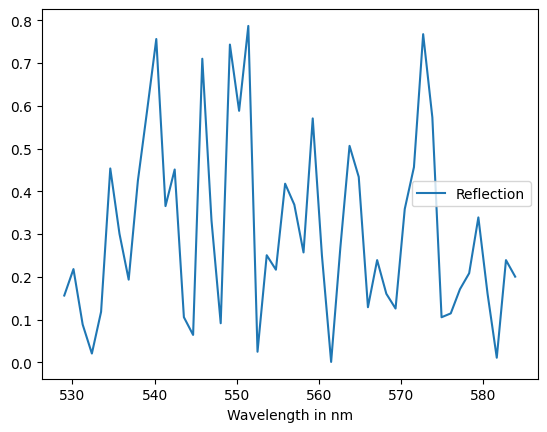

In [5]:
import matplotlib.pyplot as plt

plt.plot(wavelengths[:-1], R_s, label="Reflection")
#plt.plot(wavelengths, T_s)
plt.xlabel("Wavelength in nm")
plt.legend()
plt.show()